With that in mind, let's try to find a dataset that we can work with. There are a ton of datasets out there that current machine learning researchers use. For instance if I do a quick Google search for Deep Learning Datasets, i can see for instance a link on deeplearning.net, listing a few interesting ones e.g. http://deeplearning.net/datasets/, including MNIST, CalTech, CelebNet, LFW, CIFAR, MS Coco, Illustration2Vec, and there are ton more. And these are primarily image based. But if you are interested in finding more, just do a quick search or drop a quick message on the forums if you're looking for something in particular.

    MNIST
    CalTech
    CelebNet
    ImageNet: http://www.image-net.org/
    LFW
    CIFAR10
    CIFAR100
    MS Coco: http://mscoco.org/home/
    WLFDB: http://wlfdb.stevenhoi.com/
    Flickr 8k: http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/KCCA.html
    Flickr 30k


In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf

In [27]:
x = tf.linspace(-3.0, 3.0, 100)
print 'X is now a tensor: ',x
g = tf.get_default_graph()
#print [op.name for op in g.get_operations()]

sess       = tf.Session()

# Two ways to get value of a tf varfiable
computed_x  = x.eval(session=sess)
computed_x1 = sess.run(x)
print 'Get value of x by x.eval(): type={} , shape: {},len={} , mean={}'.format(type(computed_x),
                                                                                x.get_shape().as_list(),
                                                                                len(computed_x),                                                                   computed_x.mean())
#print 'Get value of x by run(x)  : type={} , len={} , mean={}'.format(type(computed_x1),len(computed_x1),computed_x1.mean())
sess.close()



X is now a tensor:  Tensor("LinSpace_22:0", shape=(100,), dtype=float32)
Get value of x by x.eval(): type=<type 'numpy.ndarray'> , shape: [100],len=100 , mean=9.53674330617e-08
Interactive session of x: type=<type 'numpy.ndarray'> , len=100 , mean=9.53674330617e-08


## 1-D Gaussian

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f2a217db150>> ignored


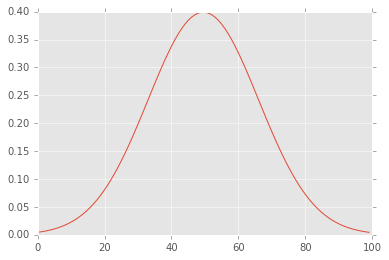

In [31]:
# simplified working with ipython console. We do not need tell eval() about session
sess       = tf.InteractiveSession()


# The 1 dimensional gaussian takes two parameters, the mean value, and the standard deviation, which is commonly denoted by the name sigma.
mean  = 0.0
sigma = 1.0

# Don't worry about trying to learn or remember this formula.  I always have to refer to textbooks or check online for the exact formula.
z = (tf.exp(tf.neg(tf.pow(x - mean, 2.0) /
                   (2.0 * tf.pow(sigma, 2.0)))) *
     (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))

res = z.eval()
plt.plot(res)

## Convolution

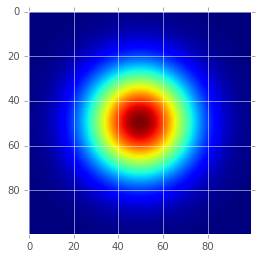

In [33]:
# Let's store the number of values in our Gaussian curve.
ksize = z.get_shape().as_list()[0]

# Let's multiply the two to get a 2d gaussian
z_2d = tf.matmul(tf.reshape(z, [ksize, 1]), tf.reshape(z, [1, ksize]))

# Execute the graph
plt.imshow(z_2d.eval())

(512, 512)
Tensor("Reshape_11:0", shape=(1, 512, 512, 1), dtype=float32)
Shape of 4D image made from 2D image with shape (512, 512) is (1, 512, 512, 1)
Shape of 4D kernel: [100, 100, 1, 1]
Shape of convolved tensor: [1, 512, 512, 1] ((1, 512, 512, 1))


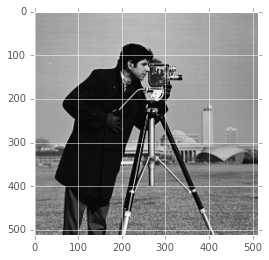

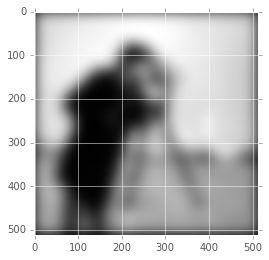

In [46]:
# Let's first load an image.  We're going to need a grayscale image to begin with.  skimage has some images we can play with.  If you do not have the skimage module, you can load your own image, or get skimage by pip installing "scikit-image".

from skimage import data
img = data.camera().astype(np.float32)
plt.figure()
plt.imshow(img, cmap='gray')
print(img.shape)

# reshape image to 4D array: n_images x H x W x n_channels
#img_4d = img.reshape([1, img.shape[0], img.shape[1], 1])
img_4d = tf.reshape(img, [1, img.shape[0], img.shape[1], 1])
print(img_4d)
print 'Shape of 4D image made from 2D image with shape {} is {}'.format(img.shape,img_4d.get_shape())

# reshape kernel to 4D array: k_H x k_W x n_input_channels X n_output_channels
# Reshape the 2d kernel to tensorflow's required 4d format: H x W x I x O
z_4d = tf.reshape(z_2d, [ksize, ksize, 1, 1])
print 'Shape of 4D kernel: {}'.format(z_4d.get_shape().as_list())

# perform the convolution with given stride vector. Basically we will use two strides:
# [1,1,1,1]  --> filter is applied with shifts of one in each direction
# [1,2,2,1]  --> filter is applied with spatial downsampling by two 
# padding = 'SAME' means that th edimensions of th eoutput image will be the same
# to those of the input image
convolved = tf.nn.conv2d(img_4d, z_4d, strides=[1, 1, 1, 1], padding='SAME')
res       = convolved.eval()
print 'Shape of convolved tensor: {} ({})'.format(convolved.get_shape().as_list(),res.shape)

# Two ways to display the resulted image
# There are a few ways we could do this.  We could plot by "squeezing" the singleton dimensions.
#plt.imshow(np.squeeze(res), cmap='gray')

# Or we could specify the exact dimensions we want to visualize:
plt.figure()
plt.imshow(res[0, :, :, 0], cmap='gray')

## Gabor filter with placeholders

- [Tensor flow math operations](https://www.tensorflow.org/versions/r0.10/api_docs/python/math_ops.html)
- [Tensor transofrmations](https://www.tensorflow.org/versions/r0.10/api_docs/python/array_ops.html)

Below is a fully parametrized Gabor filter. parameters: input_image,ksize,mean,sigma

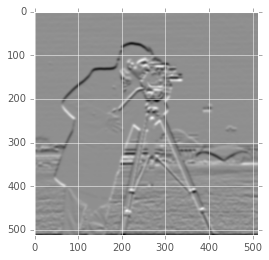

In [89]:
class GaborConv():
    def __init__(self):
        # Placeholder for 2D image of unknown dimensions
        self.img   = tf.placeholder(tf.float32, shape=[None, None], name='img')
        self.mean  = tf.placeholder(tf.float32, name='mean')
        self.sigma = tf.placeholder(tf.float32, name='sigma')
        self.ksize = tf.placeholder(tf.int32, name='ksize')

        #  Expand input image to 4D
        img_3d = tf.expand_dims(img, 2)     # 2D ==> 3D H x W     --> H x W x 1
        img_4d = tf.expand_dims(img_3d, 0)  # 3D ==> 4D H x W x 1 --> 1 x H x W x 1

        # Create a 2D Gaussian
        x = tf.linspace(-3.0, 3.0, ksize)
        z = (tf.exp(tf.neg(tf.pow(x - mean, 2.0) /
                           (2.0 * tf.pow(sigma, 2.0)))) *
              (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
        z_2d = tf.matmul(
          tf.reshape(z, tf.pack([ksize, 1])),
          tf.reshape(z, tf.pack([1, ksize])))

        # Create 1D sine wave
        ys   = tf.sin(x)
        ys   = tf.reshape(ys, tf.pack([ksize, 1]))

        ones     = tf.ones(tf.pack([1, ksize]))   # 1 x K vector  of ones
        wave     = tf.matmul(ys, ones)            # Repeat sin accross matrix
        gabor    = tf.mul(wave, z_2d)             # elementwise multiplication of wave with Gaussian
        gabor_4d = tf.reshape(gabor, tf.pack([ksize, ksize, 1, 1]))

        # And finally, convolve the two:
        convolved          = tf.nn.conv2d(img_4d, gabor_4d, strides=[1, 1, 1, 1], padding='SAME', name='convolved')
        self.convolved_img = convolved[0, :, :, 0]
    
    def apply(self,img,mean,sigma,ksize):
        r = self.convolved_img.eval(feed_dict={self.img:img,
                                               self.mean:mean,
                                               self.sigma:sigma,
                                               self.ksize:ksize})
        return r

gabor     = GaborConv()
img       = data.camera().astype(np.float32)


mean      = 0.0
sigma     = 0.5
ksize     = 32
convolved = gabor.apply(img,mean,sigma,ksize)
plt.figure()
plt.imshow(convolved, cmap='gray')

